# Introduction

Using the same transaction dataset, identify the annual salary for each customer

Explore correlations between annual salary and various customer attributes (e.g. age). These attributes could be those that are readily available in the data (e.g. age) or those that you construct or derive yourself (e.g. those relating to purchasing behaviour). Visualise any interesting correlations using a scatter plot.

Build a simple regression model to predict the annual salary for each customer using the attributes you identified above

How accurate is your model? Should ANZ use it to segment customers (for whom it does not have this data) into income brackets for reporting purposes?

For a challenge: build a decision-tree based model to predict salary. Does it perform better? How would you accurately test the performance of this model?

In [72]:
# For opening the dataset
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# For plotting our charts
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [2]:
# Load the updated dataset with customer address data
df = pd.read_excel(r'C:\Users\john.osorio\Desktop\BLACK CAT\InsideSherpa\ANZ synthesised transaction dataset ver 3.xlsx')

In [3]:
df.columns

Index(['status', 'card_present_flag', 'bpay_biller_code', 'account',
       'currency', 'long_lat', 'txn_description', 'merchant_id',
       'merchant_code', 'first_name', 'balance', 'date', 'gender', 'age',
       'merchant_suburb', 'merchant_state', 'extraction', 'amount',
       'transaction_id', 'country', 'customer_id', 'merchant_long_lat',
       'movement', 'month', 'day', 'year', 'hour', 'minute', 'seconds',
       'customer_longitude', 'customer_lattitude', 'customer_address',
       'customer_state'],
      dtype='object')

Daniel is the one with the erroneous longitude and latitude data. Let's assume his state depending on his merchant states

In [4]:
df[df.first_name == 'Daniel'].merchant_state.value_counts()

NSW    39
VIC    19
QLD    11
WA      5
SA      3
ACT     2
Name: merchant_state, dtype: int64

Since Daniel has done transactions in NSW the most, let's assume that he's living in NSW

In [5]:
df.loc[df['first_name'] == 'Daniel', 'customer_state'] = 'NSW'

# Plot all the relevant features using the account number as the index

In [6]:
ind_user_salary = df[df.txn_description == 'PAY/SALARY'].groupby('account').amount.sum()
ind_user_spend = df[df.txn_description != 'PAY/SALARY'].groupby('account').amount.sum()
ind_user_balance = df.groupby('account').balance.mean()
ind_user_gender = df.groupby('account').gender.max()
ind_user_first_name = df.groupby('account').first_name.max()
ind_user_age = df.groupby('account').age.max()
ind_user_state = df.groupby('account').customer_state.unique()
ind_user_accounts = df.account.sort_values().unique()

In [7]:
ind_user_state_array = []
for state in ind_user_state:   
    ind_user_state_array.append(state[0])

In [8]:
ind_user_cash_flow_df = pd.DataFrame({'salary' : ind_user_salary.values.reshape(1, 100)[0], 
                                      'expenditure' : ind_user_spend.values.reshape(1, 100)[0],
                                      'balance' : ind_user_balance.values.reshape(1, 100)[0],
                                      'name' : ind_user_first_name.values.reshape(1, 100)[0], 
                                      'gender' : ind_user_gender.values.reshape(1, 100)[0],
                                      'age' : ind_user_age.values.reshape(1, 100)[0],
                                      'state' : ind_user_state_array}, 
                                      index = ind_user_accounts)

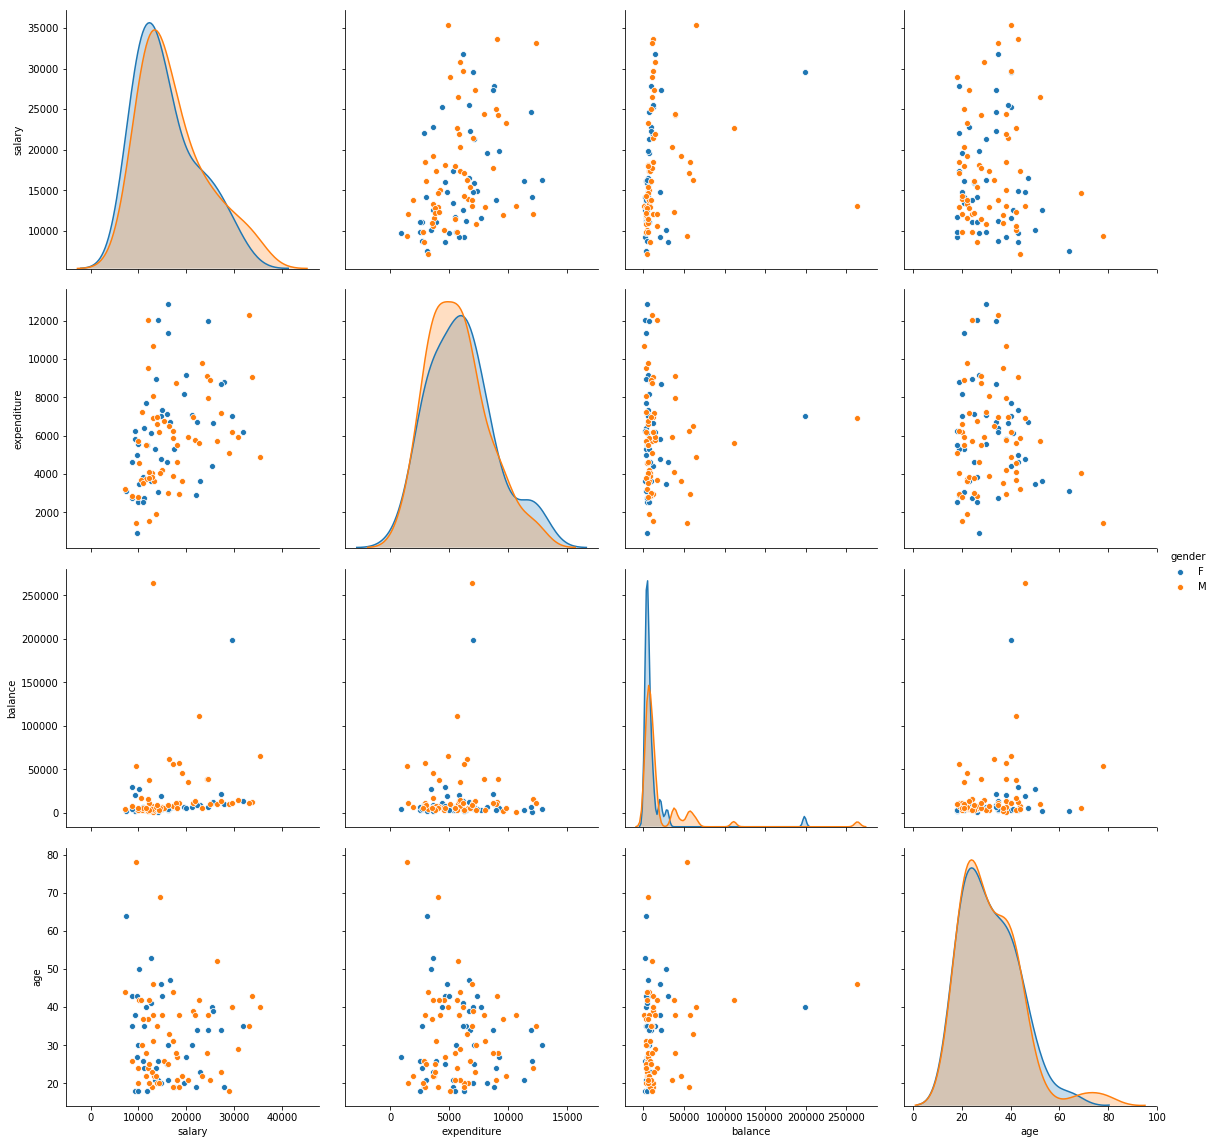

In [9]:
sns.pairplot(ind_user_cash_flow_df, hue = 'gender', height = 4)

The outliers are painfully visible. Let's remove them

In [10]:
# Create a helper function to return a list of all outliers in the data

def Z_detect_outliers(data):
    
    '''
    parameters: 
    1. data - iterative type e.g. Pandas Series or a common List
    
    returns: a List of all outliers
    
    note: do a min() on the list to identify starting point before it become outliers
    '''
    
    threshold = 3
    outliers = []
    mean = np.mean(data)
    std = np.std(data)
    
    for n in data:
        z_score = (n - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(n)
    
    return outliers

In [11]:
expenses_outliers = Z_detect_outliers(df[df.txn_description != 'PAY/SALARY'].amount)

In [12]:
min(expenses_outliers)

523.9

In [13]:
df = df[(df.txn_description == 'PAY/SALARY') | (df.amount < 523.9)]

# Update the dataframe this time without the expense outliers

In [14]:
ind_user_salary = df[df.txn_description == 'PAY/SALARY'].groupby('account').amount.sum()
ind_user_spend = df[df.txn_description != 'PAY/SALARY'].groupby('account').amount.sum()
ind_user_balance = df.groupby('account').balance.mean()
ind_user_gender = df.groupby('account').gender.max()
ind_user_first_name = df.groupby('account').first_name.max()
ind_user_age = df.groupby('account').age.max()
ind_user_state = df.groupby('account').customer_state.unique()
ind_user_accounts = df.account.sort_values().unique()

ind_user_state_array = []
for state in ind_user_state:   
    ind_user_state_array.append(state[0])
    

ind_user_cash_flow_df = pd.DataFrame({'salary' : ind_user_salary.values.reshape(1, 100)[0], 
                                      'expenditure' : ind_user_spend.values.reshape(1, 100)[0],
                                      'balance' : ind_user_balance.values.reshape(1, 100)[0],
                                      'name' : ind_user_first_name.values.reshape(1, 100)[0], 
                                      'gender' : ind_user_gender.values.reshape(1, 100)[0],
                                      'age' : ind_user_age.values.reshape(1, 100)[0],
                                      'state' : ind_user_state_array}, 
                                      index = ind_user_accounts)

# Plot the dataframe without the expense outliers

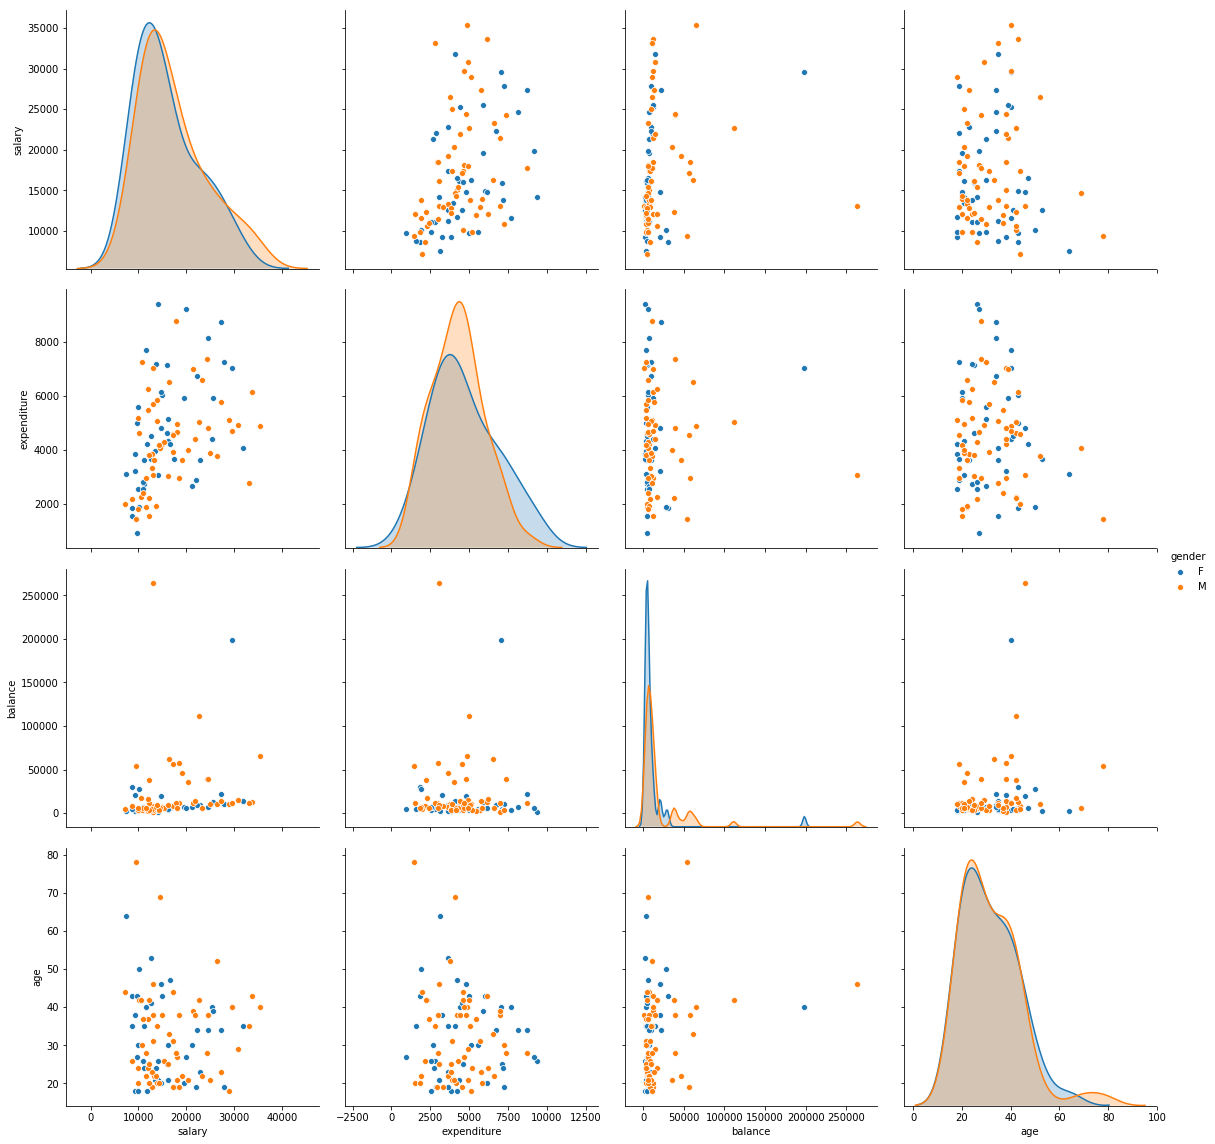

In [15]:
sns.pairplot(ind_user_cash_flow_df, hue = 'gender', height = 4)

We can see that there is some sort of positive correlation between expediture and salary. Let's have a closer look at it.

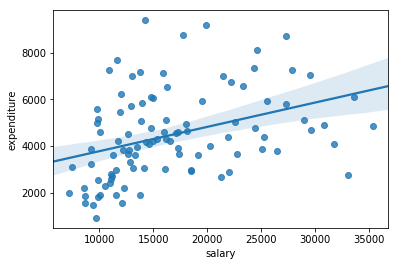

In [16]:
sns.regplot(x = 'salary', y = 'expenditure', data = ind_user_cash_flow_df)


In [17]:
pearsonr(ind_user_salary, ind_user_spend)

(0.3740830293686523, 0.000126089544953768)

So there is a little bit of positive correlation between income and expenses which makes sense because if you earn more then you tend to spend more

# Segment the dataset and include only the relevant features

I think the regression model will be more robust if I exclude the account numbers and also the customer first names. The model MAY associate the account number and first name to the test set and give a deceptively more accurate salary prediction, thus, feeding the model with an unknown customer data might not give us a very good result. 

For now I'll include the following features:

1. txn_description
2. balance
3. amount
4. gender
5. age
6. merchant_state
7. customer_state
8. customer_longitude
9  customer_lattitude

I'll need to separate the transactions into expenses and salary where salary will be the annual salary of the customer and will be the same for every observation for the particular customer. Also the transaction description categories must be encoded.

Create a new dataframe with transaction types separated

In [18]:
#Separate the main dataframe into salary and expense type transactions

pay_salary_df = df[df.txn_description == 'PAY/SALARY']
new_df = df[df.txn_description != 'PAY/SALARY']

In [19]:
# Get the quarterly salary for all the customers and put them in a dictionary so we can match them to their corresponding
# account numbers in the main dataframe

customer_salary = pay_salary_df.groupby('account').amount.apply(sum).to_dict()

In [20]:
# Now create a new column in the dataframe with the customer's quarterly salary multiplied by 4 to make it annual

new_df['salary'] = new_df.loc[:, 'account'].apply(lambda x: customer_salary.get(x) * 4)

C:\Users\john.osorio\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
new_df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,day,year,hour,minute,seconds,customer_longitude,customer_lattitude,customer_address,customer_state,salary
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,1,2018,1,1,15,153.41,-27.95,"Marine Parade, Labrador, Gold Coast, QLD, 4215...",QLD,56765.52
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,1,2018,1,13,45,153.41,-27.95,"Marine Parade, Labrador, Gold Coast, QLD, 4215...",QLD,56765.52
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,1,2018,1,26,15,151.23,-33.94,"KFC, Maroubra Road, Maroubra, Bay Gardens, Syd...",NSW,52110.76
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,1,2018,1,38,45,153.10,-27.66,"Groves Christian College, Shiraz Court, Marsde...",QLD,46388.68
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,1,2018,1,51,15,153.41,-27.95,"Marine Parade, Labrador, Gold Coast, QLD, 4215...",QLD,56765.52


Now let's only include the features that we need

In [22]:
main_df = new_df.loc[:, ['txn_description', 
                         'balance', 
                         'gender', 
                         'age', 
                         'amount', 
                         'customer_longitude', 
                         'customer_lattitude', 
                         'customer_state',
                         'salary']]

Manually set the single null value into 'WA'

In [23]:
main_df[main_df.customer_state.isnull()]

,txn_description,balance,gender,age,amount,customer_longitude,customer_lattitude,customer_state,salary
4152,SALES-POS,4357.3,F,20,5.57,115.79,-31.79,NaN,59217.08


In [24]:
main_df.loc[df['customer_state'].isnull(), 'customer_state'] = 'WA'

In [25]:
main_df.head()

,txn_description,balance,gender,age,amount,customer_longitude,customer_lattitude,customer_state,salary
0,POS,35.39,F,26,16.25,153.41,-27.95,QLD,56765.52
1,SALES-POS,21.20,F,26,14.19,153.41,-27.95,QLD,56765.52
2,POS,5.71,M,38,6.42,151.23,-33.94,NSW,52110.76
3,SALES-POS,2117.22,F,40,40.90,153.10,-27.66,QLD,46388.68
4,SALES-POS,17.95,F,26,3.25,153.41,-27.95,QLD,56765.52


In [27]:
main_df.shape

(11054, 9)

Let's apply one hot encoding on the txn_description categories

In [28]:
# encode generation labels using one-hot encoding scheme

txn_ohe = OneHotEncoder()
txn_feature_arr = txn_ohe.fit_transform(main_df[['txn_description']]).toarray()
txn_feature_labels = main_df.txn_description.sort_values().unique()
txn_features = pd.DataFrame(txn_feature_arr, columns=txn_feature_labels)
                            

In [29]:
main_df.shape

(11054, 9)

We have to reset the indices of main_df so that when we concatenate it with the txn_features, they would align and not create new rows

In [30]:
main_df.reset_index(drop=True, inplace=True)

In [31]:
main_df = pd.concat([main_df, txn_features], axis = 1)

In [32]:
main_df.head()

,txn_description,balance,gender,age,amount,customer_longitude,customer_lattitude,customer_state,salary,INTER BANK,PAYMENT,PHONE BANK,POS,SALES-POS
0,POS,35.39,F,26,16.25,153.41,-27.95,QLD,56765.52,0.0,0.0,0.0,1.0,0.0
1,SALES-POS,21.20,F,26,14.19,153.41,-27.95,QLD,56765.52,0.0,0.0,0.0,0.0,1.0
2,POS,5.71,M,38,6.42,151.23,-33.94,NSW,52110.76,0.0,0.0,0.0,1.0,0.0
3,SALES-POS,2117.22,F,40,40.90,153.10,-27.66,QLD,46388.68,0.0,0.0,0.0,0.0,1.0
4,SALES-POS,17.95,F,26,3.25,153.41,-27.95,QLD,56765.52,0.0,0.0,0.0,0.0,1.0


In [33]:
main_df.drop('txn_description', axis = 1, inplace=True)

Now convert gender into binary values 1 and 0

In [34]:
# transform and map gender
gender_list = main_df.gender.apply(lambda x: 1 if x == 'M' else 0)

In [35]:
main_df.drop('gender', axis = 1, inplace=True)

In [36]:
main_df['gender'] = gender_list

Next encode the customer state

In [37]:
cus_state_ohe = OneHotEncoder()
cus_state_arr = cus_state_ohe.fit_transform(main_df[['customer_state']]).toarray()
cus_state_labels = main_df.customer_state.sort_values().unique()
cus_state = pd.DataFrame(cus_state_arr, columns = cus_state_labels)

In [38]:
main_df = pd.concat([main_df, cus_state], axis=1)

In [39]:
main_df.drop('customer_state', axis=1, inplace=True)

# The final dataframe to be used

In [40]:
main_df.head()

,balance,age,amount,customer_longitude,customer_lattitude,salary,INTER BANK,PAYMENT,PHONE BANK,POS,SALES-POS,gender,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
0,35.39,26,16.25,153.41,-27.95,56765.52,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,21.20,26,14.19,153.41,-27.95,56765.52,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,5.71,38,6.42,151.23,-33.94,52110.76,0.0,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2117.22,40,40.90,153.10,-27.66,46388.68,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,17.95,26,3.25,153.41,-27.95,56765.52,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Now let's separate the target feature which is salary (annual)

In [41]:
y = main_df.salary
X = main_df.drop('salary', axis=1)

# Linear Regression Model

Split the data into training and test sets

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = .30)

In [43]:
# Initialize a linear regression instance
linreg = LinearRegression()

In [44]:
# Fit the model
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [45]:
salary_pred = linreg.predict(X_test)

In [46]:
# The coefficients
print('Coefficients: \n', linreg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, salary_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, salary_pred))

Coefficients: 
 [ 2.26008364e-01  1.62005885e+02  7.41270399e+00  2.02519986e+03
  3.52473387e+02  5.10466989e+03 -1.13402898e+03  9.95416255e+03
 -7.12279313e+03 -6.80201034e+03  2.16490126e+03 -4.02629471e+04
 -7.45082546e+03  3.87880249e+04 -2.56779269e+04  1.77318599e+04
 -4.24877149e+04 -5.10772165e+03  6.44672513e+04]
Mean squared error: 524402744.74
Variance score: 0.19


The R-square value is close to zero percent which means that the model doesn't explain the variation in the target variable around its mean so it's not a very good model.

In [47]:
linreg.score(X_test, y_test)

0.1943231359037606

# Decision Tree Regressor Model

Let's user Grid Search Cross Validation to determine the optimal parameters for the decision tree regressor model

In [75]:
scoring = make_scorer(r2_score)
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),
              param_grid={'min_samples_split': range(2, 10), 'max_depth': range(2, 10)},
              scoring=scoring, cv=5, refit=True)

g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
# print(result)
r2_score(y_test, g_cv.best_estimator_.predict(X_test))

0.9556934940804063

In [74]:
g_cv.best_params_

{'max_depth': 9, 'min_samples_split': 2}

# Conclusion: Using the Decision Tree model greatly improves the score of our predictions